Importações

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

from imblearn.over_sampling import SMOTE

Carregar dataset

In [3]:
file_path = 'raw_data/student_depression_dataset.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho especificado: {file_path}")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado ao carregar o dataset: {e}")
    exit()

Dataset carregado com sucesso!


Inspeção Inicial dos Dados

In [ ]:
print("\n--- Primeiras 5 linhas do Dataset ---")
print(df.head())

print("\n--- Últimas 5 linhas do Dataset ---")
print(df.tail())

In [ ]:

print("\n--- Informações Detalhadas do Dataset (tipos de dados e valores não-nulos) ---")
print(df.info())

print("\n--- Estatísticas Descritivas para Variáveis Numéricas ---")
print(df.describe())

print("\n--- Verificação de Valores Ausentes por Coluna ---")
print(df.isnull().sum())

Pré-processamento e Análise de Valores Únicos (Limpeza de Dados)

In [20]:
# Coluna 'Depression': Já é int64 (0 ou 1), não precisa de padronização adicional.
print("\n--- Valores Únicos para 'Depression' ANTES da padronização ---")
print(df['Depression'].unique())
print(f"Tipo de dado de 'Depression' ANTES: {df['Depression'].dtype}")
print("\n'Depression' já está em formato numérico (0 ou 1) e não precisa de padronização.")
print("Valores únicos para 'Depression' APÓS verificação:", df['Depression'].unique())
print(f"Tipo de dado de 'Depression' APÓS verificação: {df['Depression'].dtype}")

# Coluna 'Have you ever had suicidal thoughts ?': Converter 'Yes'/'No' para 1/0
if 'Have you ever had suicidal thoughts ?' in df.columns:
    print("\n--- Padronizando 'Have you ever had suicidal thoughts ?' ---")
    print(f"Valores únicos ANTES: {df['Have you ever had suicidal thoughts ?'].unique()}")
    df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
    print(f"Valores únicos APÓS: {df['Have you ever had suicidal thoughts ?'].unique()}")
    print(f"Tipo de dado APÓS: {df['Have you ever had suicidal thoughts ?'].dtype}")

# Coluna 'Financial Stress': Converter para numérico e tratar valores inconsistentes
if 'Financial Stress' in df.columns and df['Financial Stress'].dtype == 'object':
    print("\n--- Padronizando 'Financial Stress' para numérico ---")
    print(f"Valores únicos ANTES: {df['Financial Stress'].unique()}")
    df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors='coerce')
    if df['Financial Stress'].isnull().any():
        median_stress = df['Financial Stress'].median()
        df['Financial Stress'] = df['Financial Stress'].fillna(median_stress)
        print(f"Valores não numéricos em 'Financial Stress' foram preenchidos com a mediana ({median_stress}).")
    print(f"Valores únicos APÓS: {df['Financial Stress'].unique()}")
    print(f"Tipo de dado APÓS: {df['Financial Stress'].dtype}")


# Limpeza de Aspas e Espaços em Colunas Categóricas (Sleep Duration, Dietary Habits, Degree, Profession, City)
print("\n--- Início da Limpeza de Colunas Categóricas (aspas e espaços) ---")
cols_to_clean_strings = ['Sleep Duration', 'Dietary Habits', 'Degree', 'Profession', 'City']

for col in cols_to_clean_strings:
    if col in df.columns and df[col].dtype == 'object':
        print(f"\nProcessando coluna: '{col}'")
        df[col] = df[col].astype(str).str.replace("'", "").str.strip() # Remove aspas e espaços
        print(f"Valores únicos APÓS limpeza de aspas/espaços em '{col}': {df[col].unique()}")



--- Valores Únicos para 'Depression' ANTES da padronização ---
[1 0]
Tipo de dado de 'Depression' ANTES: int64

'Depression' já está em formato numérico (0 ou 1) e não precisa de padronização.
Valores únicos para 'Depression' APÓS verificação: [1 0]
Tipo de dado de 'Depression' APÓS verificação: int64

--- Padronizando 'Have you ever had suicidal thoughts ?' ---
Valores únicos ANTES: [nan]
Valores únicos APÓS: [nan]
Tipo de dado APÓS: float64

--- Início da Limpeza de Colunas Categóricas (aspas e espaços) ---


Verificação Final das Colunas Categóricas Após Limpeza

In [9]:
print("\n--- Verificação Final de Valores Únicos e Contagens em Colunas Categóricas Limpas ---")
# Re-seleciona colunas categóricas (tipo 'object') após todas as transformações
current_categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'id' in current_categorical_cols:
    current_categorical_cols.remove('id')

for col in current_categorical_cols:
    print(f"\nColuna '{col}':")
    print(f"  Valores únicos: {df[col].unique()}")
    print(f"  Contagem de valores: \n{df[col].value_counts()}")


--- Verificação Final de Valores Únicos e Contagens em Colunas Categóricas Limpas ---

Coluna 'Gender':
  Valores únicos: ['Male' 'Female']
  Contagem de valores: 
Gender
Male      15547
Female    12354
Name: count, dtype: int64

Coluna 'City':
  Valores únicos: ['Visakhapatnam' 'Bangalore' 'Srinagar' 'Varanasi' 'Jaipur' 'Pune' 'Thane'
 'Chennai' 'Nagpur' 'Nashik' 'Vadodara' 'Kalyan' 'Rajkot' 'Ahmedabad'
 'Kolkata' 'Mumbai' 'Lucknow' 'Indore' 'Surat' 'Ludhiana' 'Bhopal'
 'Meerut' 'Agra' 'Ghaziabad' 'Hyderabad' 'Vasai-Virar' 'Kanpur' 'Patna'
 'Faridabad' 'Delhi' 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'City' '3.0'
 'Less than 5 Kalyan' 'Mira' 'Harsha' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kibara' 'Rashi' 'ME' 'M.Com' 'Nalyan' 'Mihir' 'Nalini' 'Nandini'
 'Khaziabad']
  Contagem de valores: 
City
Kalyan                1570
Srinagar              1372
Hyderabad             1340
Vasai-Virar           1290
Lucknow               1155
Thane                 1139
Ludhiana              1111
Agra 

Análise da Variável Target (Distribuição)


--- Distribuição Atualizada da Variável Target (Depression) ---
Depression
1    16336
0    11565
Name: count, dtype: int64
Depression
1    58.549873
0    41.450127
Name: proportion, dtype: float64


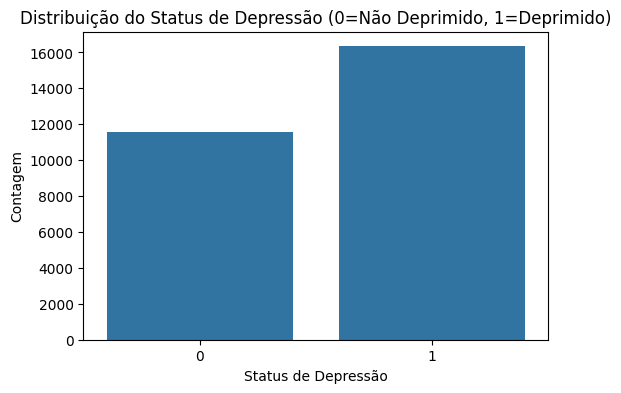

In [21]:
print("\n--- Distribuição Atualizada da Variável Target (Depression) ---")
print(df['Depression'].value_counts())
print(df['Depression'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=df)
plt.title('Distribuição do Status de Depressão (0=Não Deprimido, 1=Deprimido)')
plt.xlabel('Status de Depressão')
plt.ylabel('Contagem')
plt.show()

### Visualização de Distribuições Numéricas

In [24]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')
if 'Depression' in numerical_cols:
    numerical_cols.remove('Depression')

In [25]:
# Atualiza a lista de colunas categóricas após todas as limpezas
current_categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'id' in current_categorical_cols:
    current_categorical_cols.remove('id')

### Análise de outliers

In [37]:
# Função para calcular outliers usando método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


In [47]:
# Gráficos de visualização de outliers
def plot_outlier_visualizations(df, column, lower_bound, upper_bound):
    plt.figure(figsize=(18, 5))
    # Histograma
    plt.subplot(1, 3, 2)
    sns.histplot(df[column], bins=30, kde=True, color='orange')
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Limite Inferior')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Limite Superior')
    plt.title(f"Histograma - {column}")
    plt.legend()

    # Scatterplot por status de outlier
    plt.subplot(1, 3, 3)
    df['is_outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)
    sns.scatterplot(data=df, x=range(len(df)), y=column, hue='is_outlier', palette={True: 'red', False: 'blue'})
    plt.title(f"Dispersão com Outliers - {column}")
    plt.legend(title='Outlier')

    plt.tight_layout()
    plt.show()

In [ ]:
# Análise de outliers para cada variável numérica
outliers_summary = {}

for col in numerical_cols:
    print(f"\n--- Análise de Outliers para '{col}' ---")

    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()

    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100

    outliers_summary[col] = {
        'mean': mean_val,
        'median': median_val,
        'std': std_val,
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    print(f"  Média: {mean_val:.2f}")
    print(f"  Mediana: {median_val:.2f}")
    print(f"  Desvio Padrão: {std_val:.2f}")
    print(f"  Limite Inferior (IQR): {lower_bound:.2f}")
    print(f"  Limite Superior (IQR): {upper_bound:.2f}")
    print(f"  Número de Outliers: {outlier_count}")
    print(f"  Percentual de Outliers: {outlier_percentage:.2f}%")

    plot_outlier_visualizations(df.copy(), col, lower_bound, upper_bound)

In [49]:
# Tabela resumo
print("\n--- Tabela Resumo de Outliers ---")
summary_table = pd.DataFrame(outliers_summary).T
summary_table = summary_table.round(2)
print(summary_table[['outlier_count', 'outlier_percentage', 'mean', 'median', 'std']])


--- Tabela Resumo de Outliers ---
                                       outlier_count  outlier_percentage  \
Age                                             12.0                0.04   
Academic Pressure                                0.0                0.00   
Work Pressure                                    3.0                0.01   
CGPA                                             9.0                0.03   
Study Satisfaction                               0.0                0.00   
Job Satisfaction                                 8.0                0.03   
Have you ever had suicidal thoughts ?            0.0                0.00   
Work/Study Hours                                 0.0                0.00   
Financial Stress                                 0.0                0.00   

                                        mean  median   std  
Age                                    25.82   25.00  4.91  
Academic Pressure                       3.14    3.00  1.38  
Work Pressure        

Codificação de Variáveis Categóricas (One-Hot Encoding)

In [62]:
print("\n--- Preparando para Codificação de Variáveis Categóricas (One-Hot Encoding) ---")
print("Dataset shape antes do One-Hot Encoding:", df.shape)

# Verificar colunas com baixa cardinalidade (categorias pequenas)
low_cardinality_cols = [
    col for col in df.columns
    if df[col].nunique() > 1 and df[col].nunique() < 15 and col != 'id'
]

# Converter para string para garantir que get_dummies funcione corretamente
df[low_cardinality_cols] = df[low_cardinality_cols].astype(str)

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

print("Dataset shape APÓS One-Hot Encoding:", df.shape)
print("\n--- Primeiras 5 linhas do Dataset após One-Hot Encoding ---")
print(df.head())
print("\n--- Fim da Fase de Pré-processamento e Preparação de Dados ---")



--- Preparando para Codificação de Variáveis Categóricas (One-Hot Encoding) ---
Dataset shape antes do One-Hot Encoding: (27901, 137)
Dataset shape APÓS One-Hot Encoding: (27901, 137)

--- Primeiras 5 linhas do Dataset após One-Hot Encoding ---
   id   Age  CGPA  Have you ever had suicidal thoughts ?  \
0   2  33.0  8.97                                    NaN   
1   8  24.0  5.90                                    NaN   
2  26  31.0  7.03                                    NaN   
3  30  28.0  5.59                                    NaN   
4  32  25.0  8.13                                    NaN   

   Academic Pressure_1.0_True  Academic Pressure_2.0_True  \
0                       False                       False   
1                       False                        True   
2                       False                       False   
3                       False                       False   
4                       False                       False   

   Academic Pressure_3.0_T

Separação de Features (X) e Target (y)

In [61]:
X = df.drop(columns=['id', 'Depression'])
y = df['Depression']

print(f"\nShape de X (Features): {X.shape}")
print(f"Shape de y (Target): {y.shape}")
print("\nPrimeiras 5 linhas de X:")
print(X.head())
print("\nPrimeiras 5 linhas de y:")
print(y.head())

KeyError: "['Depression'] not found in axis"

Divisão dos Dados em Conjuntos de Treino e Teste

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

print("\nDistribuição da classe 'Depression' no conjunto de treino:")
print(y_train.value_counts(normalize=True) * 100)
print("\nDistribuição da classe 'Depression' no conjunto de teste:")
print(y_test.value_counts(normalize=True) * 100)


Shape de X_train: (22320, 109)
Shape de X_test: (5581, 109)
Shape de y_train: (22320,)
Shape de y_test: (5581,)

Distribuição da classe 'Depression' no conjunto de treino:
Depression
1    58.548387
0    41.451613
Name: proportion, dtype: float64

Distribuição da classe 'Depression' no conjunto de teste:
Depression
1    58.555814
0    41.444186
Name: proportion, dtype: float64


Balanceamento de Classes (Utilizando o SMOTE)

In [33]:
print("\n--- Realizando Balanceamento de Classes com SMOTE (apenas no conjunto de treino) ---")
print("Distribuição das classes em y_train ANTES do SMOTE:")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nDistribuição das classes em y_train APÓS o SMOTE:")
print(y_train_res.value_counts())
print(f"Novo shape de X_train após SMOTE: {X_train_res.shape}")
print(f"Novo shape de y_train após SMOTE: {y_train_res.shape}")


--- Realizando Balanceamento de Classes com SMOTE (apenas no conjunto de treino) ---
Distribuição das classes em y_train ANTES do SMOTE:
Depression
1    13068
0     9252
Name: count, dtype: int64


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Escala das Variáveis Numéricas (após SMOTE para evitar vazamento de dados)

In [36]:
numerical_cols = X_train_res.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_train_res[numerical_cols] = scaler.fit_transform(X_train_res[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nVariáveis numéricas escaladas com StandardScaler.")
print("\nPrimeiras 5 linhas de X_train_res (escalado):")
print(X_train_res.head())


Variáveis numéricas escaladas com StandardScaler.

Primeiras 5 linhas de X_train_res (escalado):
        Age  Academic Pressure  Work Pressure      CGPA  Study Satisfaction  \
0 -1.631779           0.704843      -0.009523 -1.117202           -1.469239   
1 -0.210058          -0.019570      -0.009523 -0.878353           -0.728963   
2  0.805457          -0.019570      -0.009523  1.080204           -0.728963   
3  1.617870          -0.019570      -0.009523 -0.195929            1.491865   
4 -0.210058          -0.019570      -0.009523 -0.127687            0.751589   

   Job Satisfaction  Have you ever had suicidal thoughts ?  Work/Study Hours  \
0         -0.015695                               0.877708         -1.078227   
1         -0.015695                              -1.139331          0.526960   
2         -0.015695                               0.877708         -0.543165   
3         -0.015695                               0.877708          1.329554   
4         -0.015695        

Treinamento e Avaliação dos Modelos


--- Treinando e Avaliando Modelos de Classificação ---

Modelo: Regressão Logística
  Acurácia: 0.8384
  Precisão: 0.8620
  Recall: 0.8620
  F1-Score: 0.8620
  ROC AUC: 0.9143
  Matriz de Confusão:
 [[1862  451]
 [ 451 2817]]


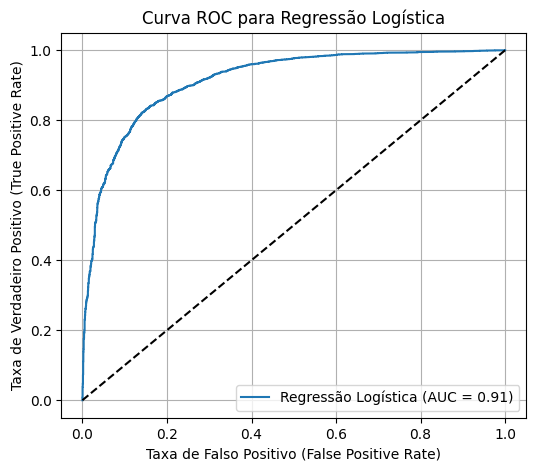


Modelo: Random Forest
  Acurácia: 0.8400
  Precisão: 0.8582
  Recall: 0.8706
  F1-Score: 0.8643
  ROC AUC: 0.9138
  Matriz de Confusão:
 [[1843  470]
 [ 423 2845]]


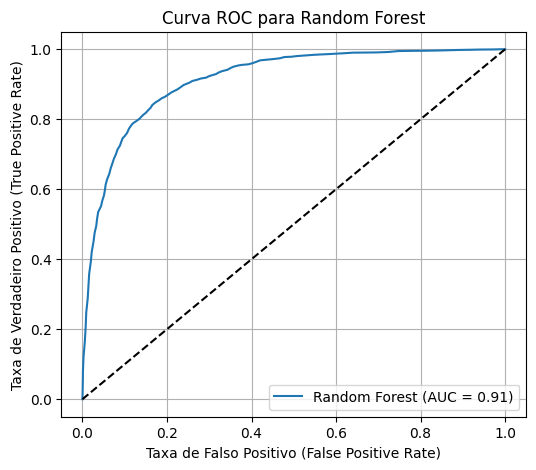


Modelo: Gradient Boosting
  Acurácia: 0.8455
  Precisão: 0.8659
  Recall: 0.8712
  F1-Score: 0.8685
  ROC AUC: 0.9186
  Matriz de Confusão:
 [[1872  441]
 [ 421 2847]]


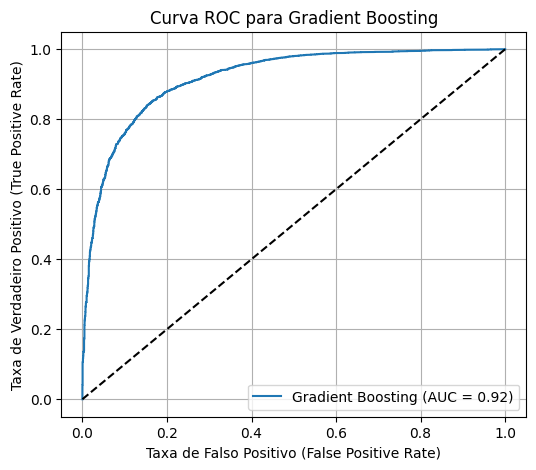


--- Resultados Comparativos dos Modelos ---

Regressão Logística:
  Acurácia: 0.8384
  Precisão: 0.8620
  Recall: 0.8620
  F1-Score: 0.8620
  ROC AUC: 0.9143

Random Forest:
  Acurácia: 0.8400
  Precisão: 0.8582
  Recall: 0.8706
  F1-Score: 0.8643
  ROC AUC: 0.9138

Gradient Boosting:
  Acurácia: 0.8455
  Precisão: 0.8659
  Recall: 0.8712
  F1-Score: 0.8685
  ROC AUC: 0.9186

--- Importância das Features (para Random Forest) ---
Have you ever had suicidal thoughts ?    0.225035
Academic Pressure                        0.156100
Financial Stress                         0.099635
Age                                      0.068501
CGPA                                     0.060576
Work/Study Hours                         0.059240
Study Satisfaction                       0.042151
Dietary Habits_Unhealthy                 0.017238
Family History of Mental Illness_Yes     0.013122
Gender_Male                              0.012765
dtype: float64


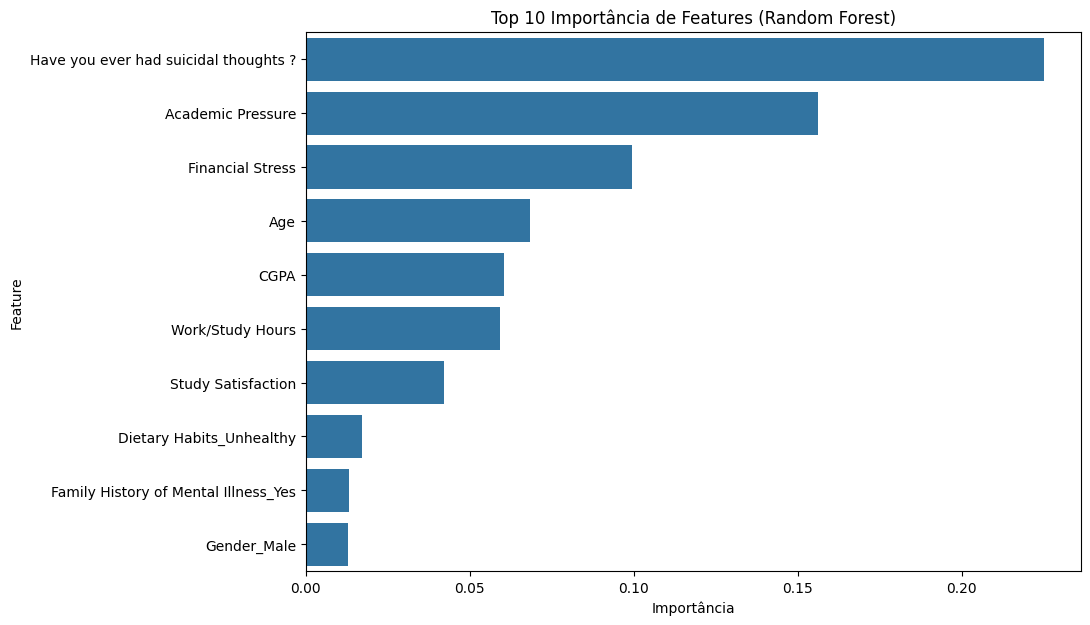


--- Fim da Fase de Modelagem Preditiva e Avaliação ---


In [39]:
print("\n--- Treinando e Avaliando Modelos de Classificação ---")

models = {
    "Regressão Logística": LogisticRegression(random_state=42, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nModelo: {name}")
    # Treinar o modelo no conjunto de treino balanceado e escalado
    model.fit(X_train_res, y_train_res)

    # Fazer previsões no conjunto de teste (NÃO balanceado, para avaliação real)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": cm
    }

    print(f"  Acurácia: {accuracy:.4f}")
    print(f"  Precisão: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("  Matriz de Confusão:\n", cm)

    # Plotar Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Linha de base (classificador aleatório)
    plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
    plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate)')
    plt.title(f'Curva ROC para {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print("\n--- Resultados Comparativos dos Modelos ---")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Acurácia: {metrics['Accuracy']:.4f}")
    print(f"  Precisão: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")
    print(f"  ROC AUC: {metrics['ROC AUC']:.4f}")

print("\n--- Importância das Features (para Random Forest) ---")
if "Random Forest" in models:
    rf_model = models["Random Forest"]
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances.head(10)) # Top 10 features

    plt.figure(figsize=(10, 7))
    sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
    plt.title('Top 10 Importância de Features (Random Forest)')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.show()


print("\n--- Fim da Fase de Modelagem Preditiva e Avaliação ---")